In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils.extmath import randomized_svd
from sklearn.decomposition import TruncatedSVD
import re
import warnings
import logging
import pickle

%matplotlib inline
pd.options.display.max_columns = 50

In [2]:
def del_read_books(recommender, yesno_df):
    recommender_mod = recommender.unstack()
    recommender_mod[yesno_df.unstack()] = np.nan
    recommender_mod = recommender_mod.unstack().transpose()
    return recommender_mod

In [3]:
# def recommend_books(userid, n_books):
#     """
#     assumes existence of
#         recommender "reconstruc_recomm_by_stars" 
#         read or not df "read_yesno"
#         book title list "order_in_recomm" 
#     also assumes userid in recommender dataFrame
#     """
#     reconstruc_recomm_by_stars_exclude_read = del_read_books(reconstruc_recomm_by_stars, read_yesno)
#     book_li = pd.DataFrame(reconstruc_recomm_by_stars_exclude_read.loc[userid].sort_values(ascending = False))
#     book_li.index = book_li.index.droplevel()
#     book_li.reset_index(inplace = True)
#     book_li.columns = ['bookid', 'match_score']
#     book_li = book_li.loc[:n_books].merge(order_in_recomm[['bookid', 'bk_title']], how = "left", on = 'bookid')
#     return book_li

### get star recommender

In [4]:
reconstruc_recomm_by_stars = pd.read_pickle("star_recommender.pkl")
read_yesno = pd.read_pickle("read_yesno.pkl")
order_in_recomm = pd.read_pickle("star_recommender_order.pkl")

In [5]:
#check it still works
recommend_books(8561, 5)

,bookid,match_score,bk_title
0,38180,3.017926,On the Beach
1,61886,3.017846,The Curse of Chalion
2,26892110,3.017201,The Library at Mount Char
3,920607,3.016680,The Arrival
4,56842,3.016511,Fatherland
5,6148028,3.015308,Catching Fire


### get holdoutset

In [6]:
book_review_holdout = pd.read_pickle("cleaned_data_holdout.pkl")
book_review_holdout = book_review_holdout[['bookid', 'userid', 'review_rating', 'user_tot_reviews']]
book_review_holdout.tail(1)

,bookid,userid,review_rating,user_tot_reviews
2033,6261189,4765786,5,3


### eval

In [72]:
reconstruc_recomm_by_stars_exclude_read = del_read_books(reconstruc_recomm_by_stars, read_yesno)
eval_df = reconstruc_recomm_by_stars_exclude_read.transpose()
# eval_df = eval_df.rank(axis = 0, pct = True)
eval_df = pd.DataFrame(eval_df.stack())
eval_df.columns = ['recomm_stars']
eval_df.reset_index(inplace = True)
del eval_df['level_0']
eval_df = book_review_holdout.merge(eval_df, how = "left", on = ['bookid', 'userid'])
eval_df.tail(2)

,bookid,userid,review_rating,user_tot_reviews,recomm_stars
2032,99383,13070326,4,12,3.595329
2033,6261189,4765786,5,3,2.979483


In [73]:
eval_df['log_user_tot_reviews'] = eval_df['user_tot_reviews'].map(np.log)

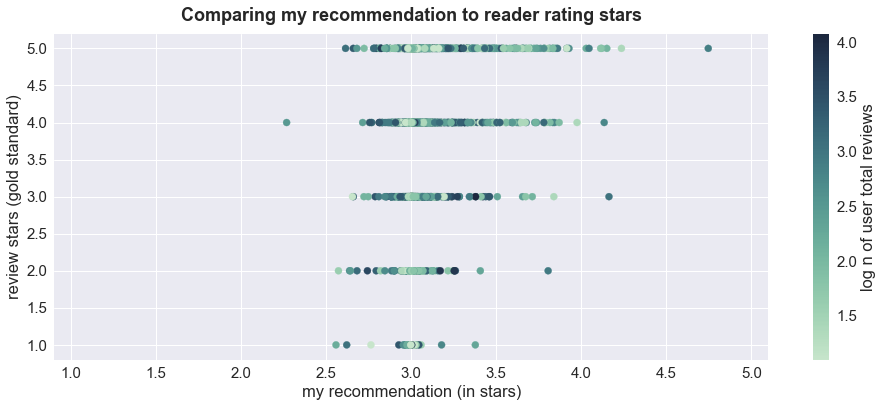

In [132]:
plt.figure(figsize = (16, 6))
sns.set(font_scale=1.5) 
cmap = sns.cubehelix_palette(rot=-.4, as_cmap=True)
plt.scatter(eval_df['recomm_stars'], eval_df['review_rating'], c = eval_df['log_user_tot_reviews'], \
            cmap = cmap, s = 50)
plt.colorbar(label = "log n of user total reviews")
plt.xlim([0.9, 5.1])
plt.ylim([0.8, 5.2])
plt.ylabel(r"review stars (gold standard)")
plt.xlabel(r"my recommendation (in stars)")
plt.title("Comparing my recommendation to reader rating stars", y=1.02, fontweight="bold")
plt.show()

In [124]:
# sns.set(font_scale=2) 
# g = sns.lmplot('recomm_stars', 'log_user_tot_reviews', data=eval_df, hue='review_rating', legend=False, \
#                fit_reg=False, palette=sns.color_palette("RdBu_r", 5), size=8, aspect=2)
# g.fig.suptitle("Comparing my recommendation to reader rating stars", y=1.02)
# g.set_axis_labels(r"my recommendation (in stars)", "log n of user total reviews")
# g.add_legend(title= r"review stars (gold standard)")
# plt.show() # TODO try a different ranking!

### pickle eval

In [133]:
eval_df.to_pickle("eval_star_recommender.pkl")